In [1]:
!pip install  dgl -f https://data.dgl.ai/wheels/torch-2.4/cu124/repo.html --quiet
!pip install torchmetrics==1.4.2 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.3/797.3 MB 801.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import networkx as nx

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributed as dist
import torchmetrics

import os
import argparse
os.environ["DGLBACKEND"] = "pytorch"

import dgl
import dgl.data
from dgl.nn import GATv2Conv, GlobalAttentionPooling
from dgl.dataloading import GraphDataLoader
from dgl.data import DGLDataset

In [3]:
# Reading a file with node types list . Upload the all_node_types.pkl file .

unpickled_df = pd.read_pickle("/content/all_node_types.pkl")
ar = [str(item) for item in unpickled_df]
instructions = dict(zip(ar, range(1, len(ar)+1)))

In [4]:
# Reading the dataset .
# Our dataset is in 3 separate files - node.csv , edges.csv , properties.csv
# Upload them

nodes = pd.read_csv("/content/nodes.csv")
edges = pd.read_csv("/content/edges.csv")
properties = pd.read_csv("/content/properties.csv")

properties_train, properties_test = train_test_split(properties, test_size=0.33, random_state=42)

matching_id = nodes["cfg_id"].isin(properties_test["cfg_id"])
nodes_test = nodes.loc[matching_id, :]
matching_id = nodes["cfg_id"].isin(properties_train["cfg_id"])
nodes_train = nodes.loc[matching_id, :]
matching_id = edges["cfg_id"].isin(properties_test["cfg_id"])
edges_test = edges.loc[matching_id, :]
matching_id = edges["cfg_id"].isin(properties_train["cfg_id"])
edges_train = edges.loc[matching_id, :]

In [5]:
class MyUtils(object):
    @staticmethod
    def init_process_group(world_size, rank):
        dist.init_process_group(
            backend="gloo",  # change to 'nccl' for multiple GPUs
            init_method="tcp://127.0.0.1:12345",
            world_size=world_size,
            rank=rank,
        )

    @staticmethod
    def get_feature(batchg):
        return torch.cat(
            (batchg.ndata["instruction_type"],),
            1,
        )

    @staticmethod
    def try_gpu(i=0):
        if i < 0:
            return torch.device("cpu")
        if torch.cuda.device_count() >= i + 1:
            return torch.device(f"cuda:{i}")
        return torch.device("cpu")

    @staticmethod
    def class_weight(train_dataset, device):
        neg, pos = np.bincount(train_dataset.labels.tolist())
        weight = [(1.0 / neg) * (pos + neg) / 2.0, (1.0 / pos) * (pos + neg) / 2.0]
        return torch.FloatTensor(weight).to(device)

    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)

    @staticmethod
    def accuracy(y_hat, y):
        if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
            y_hat = argmax(y_hat, axis=1)
        cmp = astype(y_hat, y.dtype) == y
        return float(reduce_sum(astype(cmp, y.dtype)))

    @staticmethod
    def trainEpoch(net, trainDataLoader, loss, weight, updater, device):
        if isinstance(net, torch.nn.Module):
            net.train()

        metric = MyAccumulator(3)

        for X, y in trainDataLoader:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y, weight=weight)
            updater.zero_grad()
            l.backward()
            updater.step()
            with torch.no_grad():
                metric.add(
                    l * X.batch_size,
                    MyUtils.accuracy(y_hat, y),
                    X.batch_size,
                )
        return metric[0] / metric[2], metric[1] / metric[2]


class MyAccumulator(object):
    """For accumulating sums over `n` variables."""

    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
argmax = lambda x, *args, **kwargs: x.argmax(*args, **kwargs)
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)

In [6]:
class MyGATv2(nn.Module):

    def __init__(
        self,
        h_dim,
        num_classes,
        num_heads,
        feat_dropout,
        attn_dropout,
        layers,
        in_dimN=15,
    ) -> None:
        super(MyGATv2, self).__init__()

        self.convsN = nn.Sequential(
            GATv2Conv(
                in_dimN,
                h_dim,
                num_heads=num_heads,
                feat_drop=feat_dropout,
                attn_drop=attn_dropout,
                residual=True,
                activation=F.relu,
                allow_zero_in_degree=True,
            )
        )

        for i in range(1, layers):
            self.convsN.add_module(
                str(i),
                GATv2Conv(
                    h_dim * num_heads,
                    h_dim,
                    num_heads=num_heads,
                    feat_drop=feat_dropout,
                    attn_drop=attn_dropout,
                    residual=True,
                    activation=F.relu,
                    allow_zero_in_degree=True,
                ),
            )

        self.gPool = GlobalAttentionPooling(nn.Linear(h_dim * num_heads, 1))
        self.dropout = nn.Dropout(feat_dropout)

        self.linear = nn.Linear(h_dim * num_heads, 2 * h_dim)
        self.classify = nn.Linear(2 * h_dim, num_classes)

    def forward(self, g):
        hN = MyUtils.get_feature(g)

        hg = None
        for i in range(len(self.convsN)):
            hN = F.relu(self.convsN[i](g, hN).flatten(1))

            with g.local_scope():
                g.ndata["h"] = hN
                newhN = dgl.softmax_nodes(g, "h")

                if hg == None:
                    hg = self.gPool(g, newhN)
                else:
                    hg = hg + self.gPool(g, newhN)

        return self.classify(F.relu(self.dropout(self.linear(hg))))

In [10]:
class CFGDatasetForPy(DGLDataset):
    def __init__(
        self,
        trainProjectName,
        trainVersion,
        testProjectName,
        testVersion,
        isTraining,
    ):
        self.instruction = instructions
        self.instruction_enc = F.one_hot(torch.arange(len(self.instruction) + 1))

        self.project, self.version = (
            (trainProjectName, trainVersion)
            if isTraining
            else (testProjectName, testVersion)
        )
        super().__init__(name="CFG")

    def process(self):
        if self.project == 'train':
            nodes = nodes_train
            edges = edges_train
            properties = properties_train
        else:
            nodes = nodes_test
            edges = edges_test
            properties = properties_test

        self.graphs = []
        self.labels = []

        label_dict = {}
        num_nodes_dict = {}
        for _, row in properties.iterrows():
            label_dict[row["cfg_id"]] = 1 if row["label"] >= 1 else 0
            num_nodes_dict[row["cfg_id"]] = row["num_nodes"]

        edges_group = edges.groupby("cfg_id")
        nodes_group = nodes.groupby("cfg_id")

        for graph_id in edges_group.groups:
            edges_of_id = edges_group.get_group(graph_id)
            nodes_of_id = nodes_group.get_group(graph_id).sort_values(by="node_id")
            src = edges_of_id["src"].to_numpy()
            dst = edges_of_id["dst"].to_numpy()
            num_nodes = num_nodes_dict[graph_id]
            label = label_dict[graph_id]

            g = dgl.graph((src, dst), num_nodes=num_nodes)

            itList = []
            for iv in nodes_of_id["instruction_type"]:
                itList.append(
                    self.instruction_enc[self.instruction[iv]]
                    if self.instruction[iv]
                    else self.instruction_enc[0]
                )

            g.ndata["instruction_type"] = torch.stack(itList).float()

            # removing isolated nodes from our graph
            isolated_nodes = ((g.in_degrees() == 0) & (g.out_degrees() == 0)).nonzero().squeeze(1)
            g.remove_nodes(isolated_nodes)

            self.graphs.append(g)
            self.labels.append(label)

        self.labels = torch.LongTensor(self.labels)

    def __getitem__(self, i):
        return self.graphs[i], self.labels[i]

    def __len__(self):
        return len(self.graphs)


def evaluate(net, data_iter, device):
    if isinstance(net, torch.nn.Module):
        net.eval()
    net.to(device)

    y, y_hat = [], []
    labels, preds = [], []

    with torch.no_grad():
        for X, y in data_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)

            preds.append(y_hat.argmax(1))
            labels.append(y)

        return (
            torchmetrics.functional.precision(
                torch.cat(preds), torch.cat(labels), "binary"
            ),
            torchmetrics.functional.recall(
                torch.cat(preds), torch.cat(labels), "binary"
            ),
            torchmetrics.functional.fbeta_score(
                torch.cat(preds), torch.cat(labels), "binary", beta=1.0
            ),
            torchmetrics.functional.auroc(
                torch.cat(preds).float(), torch.cat(labels), "binary"
            ),
            torchmetrics.functional.matthews_corrcoef(
                torch.cat(preds).float(), torch.cat(labels), "binary"
            ),
        )


def train(net, train_iter, num_epochs, updater, scheduler, device):
    net.apply(MyUtils.weight_init)
    weight = MyUtils.class_weight(train_iter.dataset, device)
    net.to(device)
    for epoch in range(num_epochs):
        train_loss, train_acc = MyUtils.trainEpoch(
            net,
            train_iter,
            F.cross_entropy,
            weight,
            updater,
            device,
        )
        scheduler.step()
        if epoch % 10 == 0:
            print(
                "Epoch {}: train loss {:.4f}  train acc: {:.5f} \n".format(
                    epoch, train_loss, train_acc
                ),
                flush=True,
            )


def sdpProcess(
    trainProjectName,
    testProjectName,
    trainVersion,
    testVersion,
    device,
    layers,
    hiddens,
    par_epochs,
    par_num_heads,
):
    lr, epochs, batch_size, dropout = (1e-4, par_epochs, 32, 0.4)
    schedulerStepSize, schedulerGamma = 16, 0.9
    hidden_dim, num_heads = hiddens, par_num_heads

    model = MyGATv2(hidden_dim, 2, num_heads, dropout, dropout, layers, 151)

    trainDataset, testDataset = CFGDatasetForPy(
        trainProjectName, trainVersion, testProjectName, testVersion, True
    ), CFGDatasetForPy(
        trainProjectName, trainVersion, testProjectName, testVersion, False
    )

    trainDataloader, testDataloader = GraphDataLoader(
        trainDataset, batch_size=batch_size, drop_last=False
    ), GraphDataLoader(testDataset, batch_size=batch_size, drop_last=False)

    optimizer = optim.Adam(model.parameters(), lr)
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer=optimizer, step_size=schedulerStepSize, gamma=schedulerGamma
    )

    print(
        "training start: {}--{}-----{}--{}\n".format(
            trainProjectName, trainVersion, testProjectName, testVersion
        ),
        flush=True,
    )

    train(model, trainDataloader, epochs, optimizer, scheduler, device)

    metric_all = evaluate(model, testDataloader, device)

    print(
        "===========P=============\n{}\n===========R=============\n{}\n===========F1=============\n{}\n===========AUC=============\n{}\n===========MCC=============\n{}\n".format(
            metric_all[0].item(),
            metric_all[1].item(),
            metric_all[2].item(),
            metric_all[3].item(),
            metric_all[4].item(),
        ),
        flush=True,
    )

In [11]:

for i in range(1):
    sdpProcess(
        'train',
        'test',
        'train',
        'test',
        MyUtils.try_gpu(),
        4,
        64,
        50,
        8,
    )

training start: train--train-----test--test

Epoch 0: train loss 0.7082  train acc: 0.49652 

Epoch 10: train loss 0.6914  train acc: 0.52362 

Epoch 20: train loss 0.6907  train acc: 0.52487 

Epoch 30: train loss 0.6906  train acc: 0.52785 

Epoch 40: train loss 0.6893  train acc: 0.53136 

===========P=============
0.5209524035453796
===========R=============
0.6598311066627502
===========F1=============
0.5822246074676514
===========AUC=============
0.5245488286018372
===========MCC=============
0.051002137362957



In [12]:
trainDataset, testDataset = CFGDatasetForPy(
    "train", "train", "test", "test", True
    ), CFGDatasetForPy(
    "train", "train", "test", "test", False
)

In [36]:
options = {
    'node_color': 'black',
    'node_size': 20,
    'width': 1,
}
def draw_graph(ind):
  g = trainDataset[ind][0]
  has_bug = trainDataset[ind][1].item()
  print('Label :', has_bug)
  G = dgl.to_networkx(g, node_attrs=['instruction_type'])
  plt.figure(figsize=[8,5])
  labels = nx.get_node_attributes(G, 'instruction_type')
  labels_tmp = [torch.nonzero(labels[i]).item() for i in range(len(labels))]
  labels_inst = [list(instructions.keys())[list(instructions.values()).index(ind)] for ind in labels_tmp]
  nx.draw(G, **options, with_labels = True, labels=dict(zip(range(len(labels_inst)), labels_inst)))

train_labels=[trainDataset[ind][1].item() for ind in range(len(trainDataset))]
test_labels=[testDataset[ind][1].item() for ind in range(len(testDataset))]
print(f'Class ratio in train -    {sum(train_labels)/len(trainDataset):.2f} : {(len(trainDataset)-sum(train_labels))/len(trainDataset):.2f}')
print(f'Class ratio in test -    {sum(test_labels)/len(testDataset):.2f} : {(len(testDataset)-sum(test_labels))/len(testDataset):.2f}')

Class ratio in train -    0.50 : 0.50
Class ratio in test -    0.50 : 0.50


Label : 1


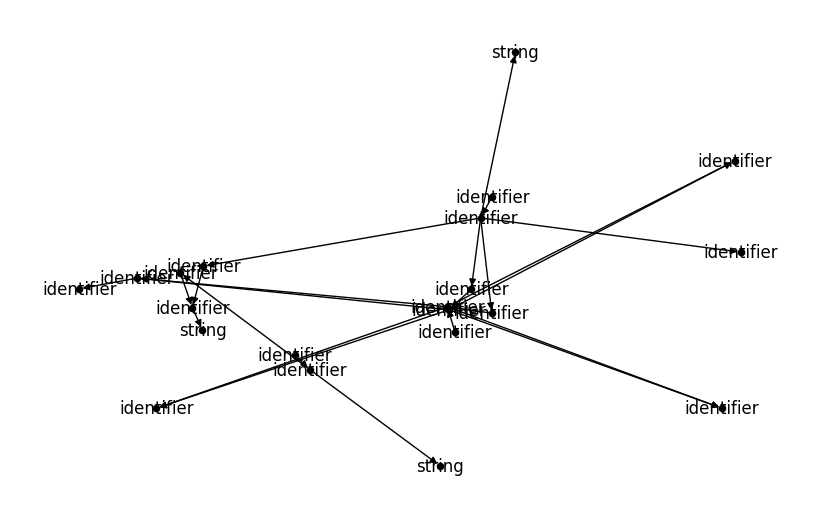

In [26]:
draw_graph(0)

Label : 0


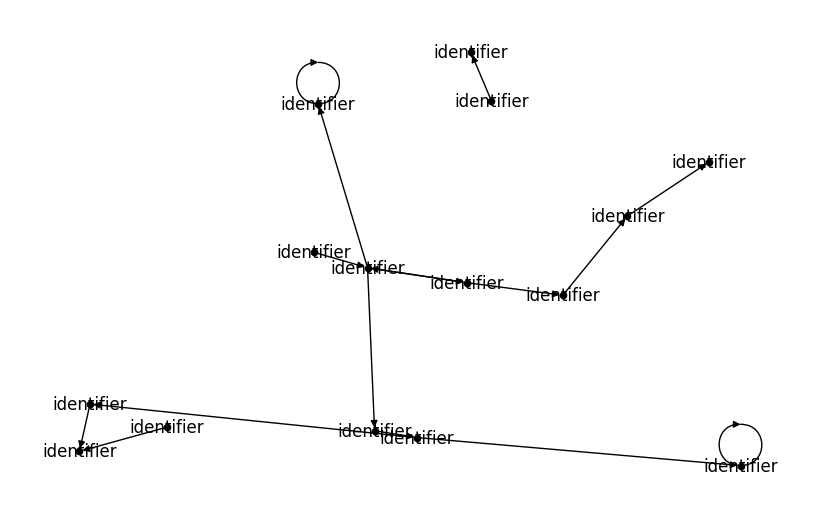

In [27]:
draw_graph(1)

Label : 1


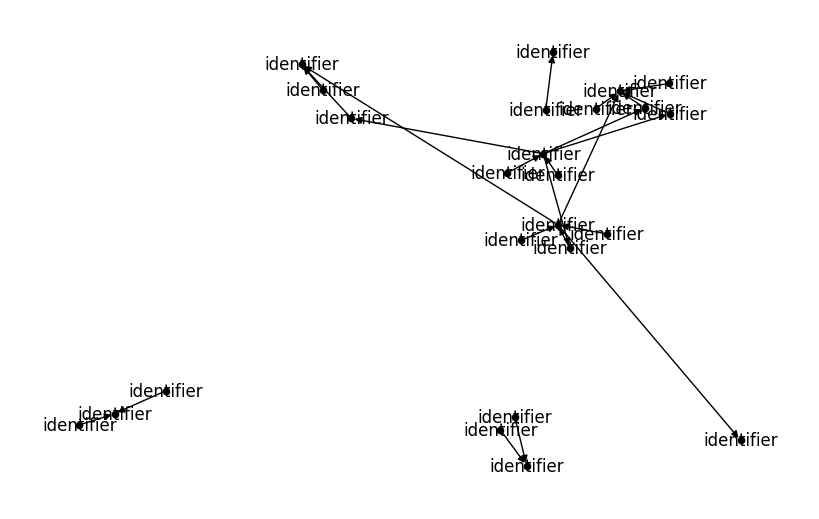

In [28]:
draw_graph(2)

Label : 1


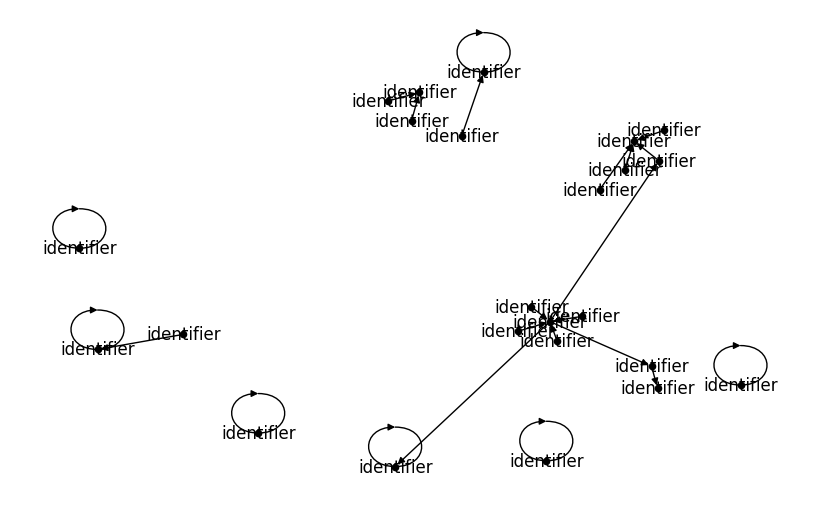

In [29]:
draw_graph(3)

Label : 0


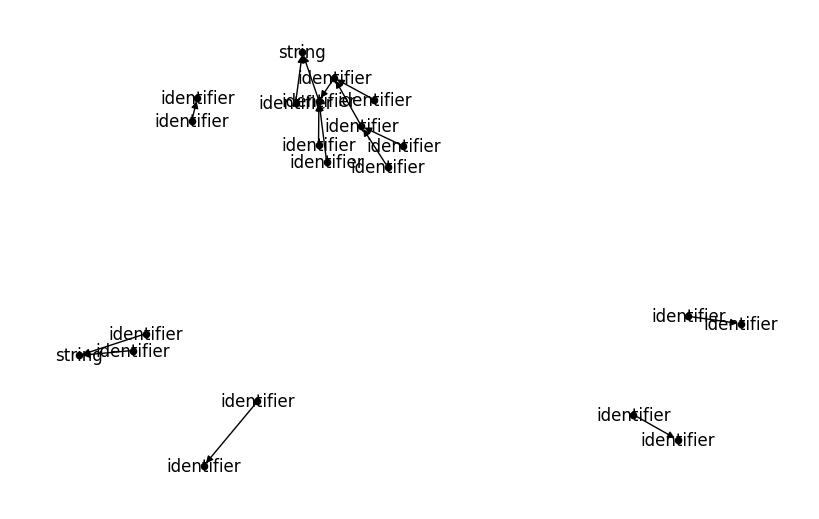

In [34]:
draw_graph(6)